<a href="https://colab.research.google.com/github/kalaiselvan-t/Deep-Learning/blob/master/Predicting%20house%20prices%20(Boston%20housing%20price%20dataset)%20%3A%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting house prices - Regression

**Regression: ** The process of predicting continuous values instead of a discrete label like classification

**Note: ** Do not confuse regression with logistic regression. Logistic regression is not a regression algorithm, it is an classification algorithm

**Goal: ** To predict the median of house prices in a given Boston suburb in mid 1970's

**Datset: ** Only has 506 data points. 404 - training samples. 102 test samples. Each feature in the dataset has different scale

## Loading the dataset

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

## Preparing the data

- Each feature has different scale
- NN are capable of dealing with such heterogeneous data, but it would make learning harder
- Best practice is to do a **feature-wise normalization** : for each feature in the input data (column in the input data matrix) , you subtract the mean of the feature and divide by the standard deviation, so the feature is centered around 0 and has unit standard deviation

In [ ]:
import numpy as np

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# Note: mean of the test data is used
test_data -= mean
test_data /= std

## Building the network

- A small network with 2 hidden layers is used, because of the small no of datapoints
- Each layer has 64 units

The less training data we have, the worse is the overfitting problem. We can mitigate it by using a small network

In [ ]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))    # No activation means it will be a linear layer - the network is free to learn to predict values in any range

  model.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['mae'])
  return model

## Validating the approach using K-fold validation

To evaluate the network while we change its parameters like epochs etc., we could split the training data into a training set and validation set. This approach won't work here, because of the small size of the dataset.

The best practice in such situations is to use **K-fold cross-validation:** It consists of splitting the available data into k partitions (typically k = 4 or 5), instantiating k identical models and training each one on k-1 partitions.

The validation score for the model used is then the average of the k validation scores obtained.

In [ ]:
k = 4

num_val_samples = len(train_data) // k
no_epochs = 100
all_scores = []

for i in range(k):
  print('Processing fold #', i)

  val_data = train_data[ i * num_val_samples : ((i + 1) * num_val_samples)]
  val_targets = train_targets[ i * num_val_samples: ((i + 1) * num_val_samples)]

  partial_train_data = np.concatenate(
      [train_data[: i * num_val_samples],
      train_data[(i+1) * num_val_samples:]],
      axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i+1) * num_val_samples:]],
       axis=0
  )
  
  model = build_model()

  model.fit(partial_train_data,
            partial_train_targets,
            epochs=no_epochs,
            batch_size=1,
            verbose=0)
  val_mse, val_mae = model.evaluate(val_data,
                                    val_targets,
                                    verbose=0)
  all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


## Update

In [ ]:
k = 4
no_epochs = 500
all_mae_histories = []

for i in range(k):
  print('Processing fold #', i)
  
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i+1) * num_val_samples:]],
       axis = 0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i+1) * num_val_samples:]],
       axis=0
  )

  model = build_model()

  history = model.fit(partial_train_data,
                      partial_train_targets,
                      epochs=no_epochs,
                      batch_size=1,
                      verbose=0,
                      validation_data=(val_data, val_targets)
                      )
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [ ]:
print(all_mae_histories)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(no_epochs)]

[[3.4143385887145996, 2.812760353088379, 2.6720192432403564, 2.443725824356079, 2.5710041522979736, 2.3657212257385254, 2.4030401706695557, 2.160616636276245, 2.198253870010376, 2.180187463760376, 2.138274908065796, 2.321502447128296, 2.080371618270874, 1.960192084312439, 2.0190110206604004, 2.0402824878692627, 2.0165910720825195, 2.0163536071777344, 2.0858583450317383, 1.9698885679244995, 1.9865450859069824, 2.077650785446167, 1.8489010334014893, 1.819055438041687, 2.2332420349121094, 1.9253813028335571, 2.106630802154541, 2.0878238677978516, 2.062580108642578, 1.9720057249069214, 1.8680585622787476, 2.186203956604004, 2.375535488128662, 1.9397631883621216, 1.8940693140029907, 1.9953418970108032, 2.1334567070007324, 2.141083002090454, 2.0674571990966797, 2.032592296600342, 2.062274217605591, 1.9188414812088013, 2.0191640853881836, 1.8683439493179321, 1.930625557899475, 2.029669761657715, 1.9104089736938477, 1.930930733680725, 2.02142071723938, 1.8483083248138428, 1.9417725801467896, 1

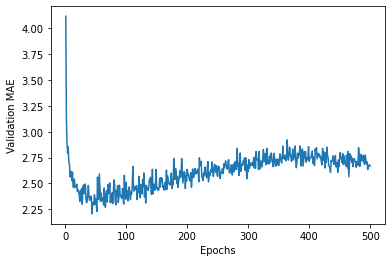

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1),
         average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

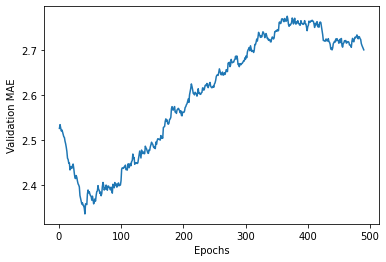

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1),
         smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Training the final model

In [ ]:
model = build_model()

model.fit(partial_train_data,
          partial_train_targets,
          epochs=80,
          batch_size=16,
          verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 5ms/step - loss: 19.3291 - mae: 2.9203


In [ ]:
test_mae_score

In [ ]:
predictions = model.predict(test_data)

In [ ]:
predictions[100]